# Lab 4 - Phys 434
## Andrew Spicciati
## 10/26/21

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py
import pandas as pd

from ipywidgets import interact

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (10,7)

In [2]:
hf = h5py.File('gammaray_lab4.h5', 'r')

In [3]:
hf.keys()

<KeysViewHDF5 ['data']>

In [4]:
data = np.array(hf.get('data'))
data[:,0]

array([9.40680016e+08, 3.15000000e+02, 4.50000000e+01, 1.00000000e+01])

In [5]:
hf.close()

In [6]:
hf

<Closed HDF5 file>

# Problem 1

## 1) a series of plots to understand the data

In [7]:
#opening the data and putting it into an array
hf = h5py.File('gammaray_lab4.h5', 'r')
data = np.transpose(np.array(hf.get('data')))

columns = ['Time','Solar Phase','Longitude','Particle Counts']

df = pd.DataFrame(columns = columns, data = data)

In [8]:
df

,Time,Solar Phase,Longitude,Particle Counts
0,940680016.0,315.000000,45.000000,10.0
1,940680016.1,315.007112,45.006667,8.0
2,940680016.2,315.014225,45.013333,7.0
3,940680016.3,315.021337,45.020000,11.0
4,940680016.4,315.028449,45.026667,8.0
...,...,...,...,...
25919996,943272015.6,345.304884,44.973333,5.0
25919997,943272015.7,345.311996,44.980000,9.0
25919998,943272015.8,345.319109,44.986667,8.0
25919999,943272015.9,345.326221,44.993333,11.0


In [9]:
#showing the range of the particle counts, so I can use this as my number of bins on the y-axis
max(df['Particle Counts']) - min(df['Particle Counts'])

30.0

#### 1.
First, I show the general distribution of Particle Counts. It is clear that this is a Poisson distribution.

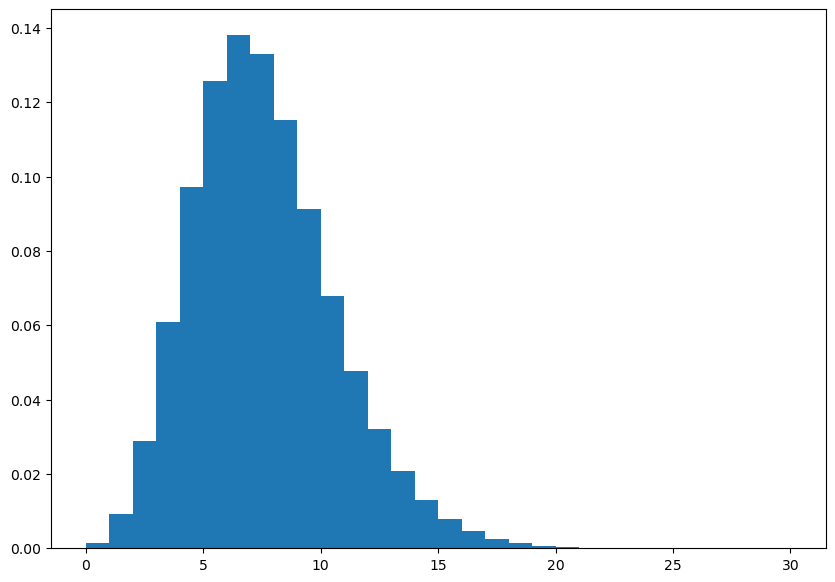

In [10]:
plt.hist(df['Particle Counts'],bins = 30, density=True);

#### 2.
Here is a plot that shows an element of the data that has no signal contamination. As we can see, the distribution of Particle Counts is not dependent of Solar Phase.

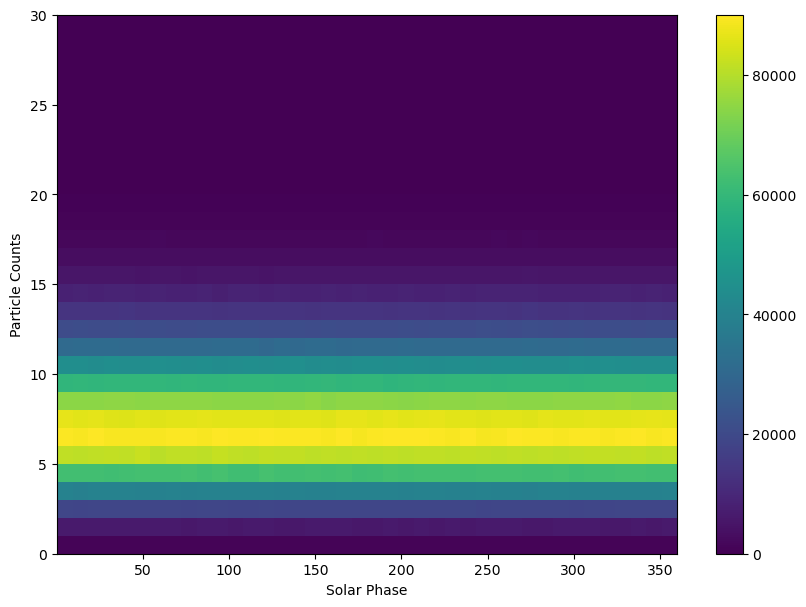

In [11]:
plt.hist2d(df['Solar Phase'],df['Particle Counts'],bins=(40,30))
plt.colorbar()

plt.xlabel('Solar Phase')
plt.ylabel('Particle Counts');

#### 3.
Next, I made some plots with time, and here I do notice a dependance. The period of the dependance is the same as the period of orbit, 5400 seconds.

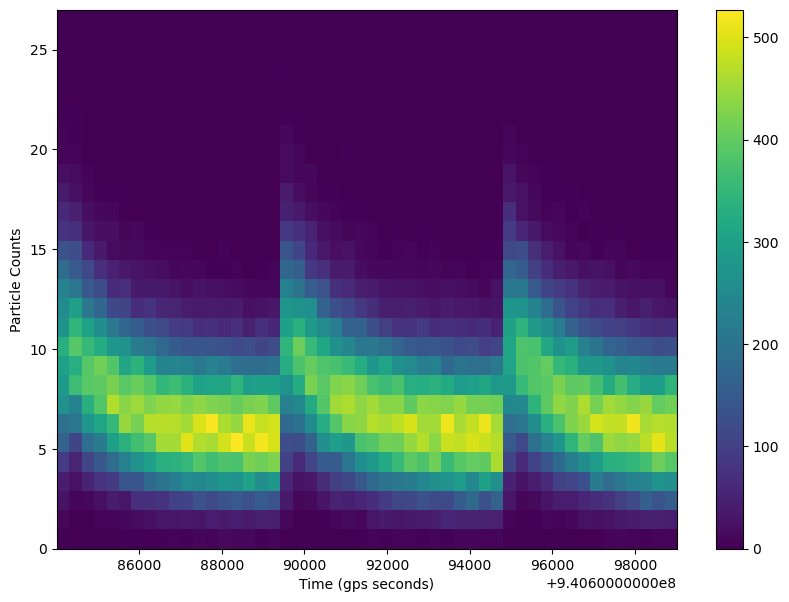

In [12]:
plt.hist2d(df['Time'][40000:190000],df['Particle Counts'][40000:190000],bins=(40,28))
plt.colorbar()

plt.xlabel('Time (gps seconds)')
plt.ylabel('Particle Counts');

#### 4.
By folding the Time axis by the period, I can show the average dependence per period of orbit.

In [13]:
fold = df['Time'] % (90*60)

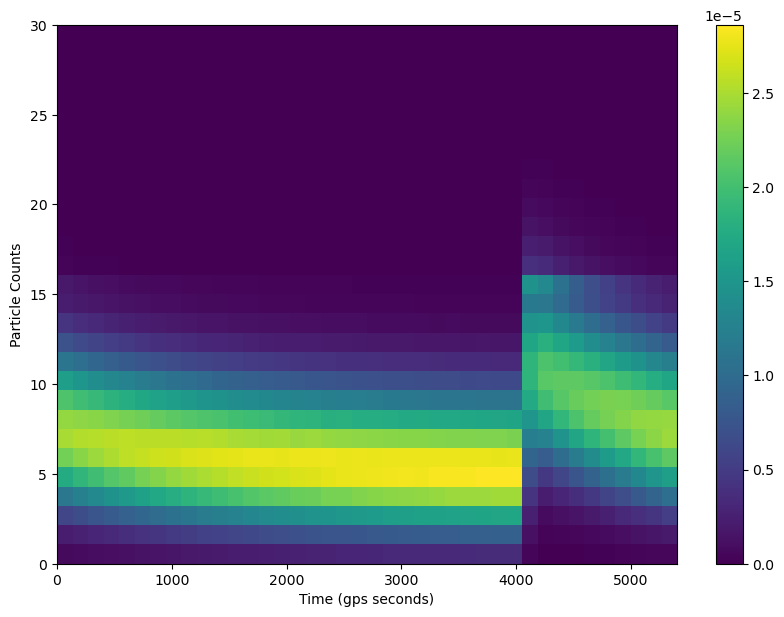

In [14]:
plt.hist2d(fold,df['Particle Counts'],bins=(40,28), density=True)
plt.colorbar()

plt.xlabel('Time (gps seconds)')
plt.ylabel('Particle Counts');

#### 5.
Next I plot longitude, and notice that it has the same dependence as time. This makes sense because longitude is varying at the same rate as time is. Going forward I decide to work with longitude, because it doesn't require being folded. 

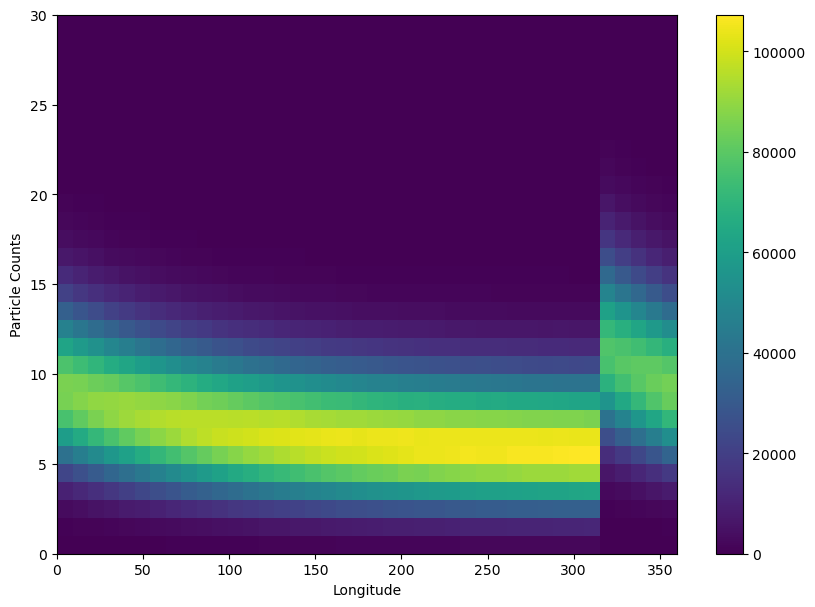

In [15]:
plt.hist2d(df['Longitude'],df['Particle Counts'],bins=(40,30))
plt.colorbar()

plt.xlabel('Longitude')
plt.ylabel('Particle Counts');

#### 6.
I shift the data so it is continuous from 0 to 360.

In [16]:
longitude = (df['Longitude'] + 45) % 360

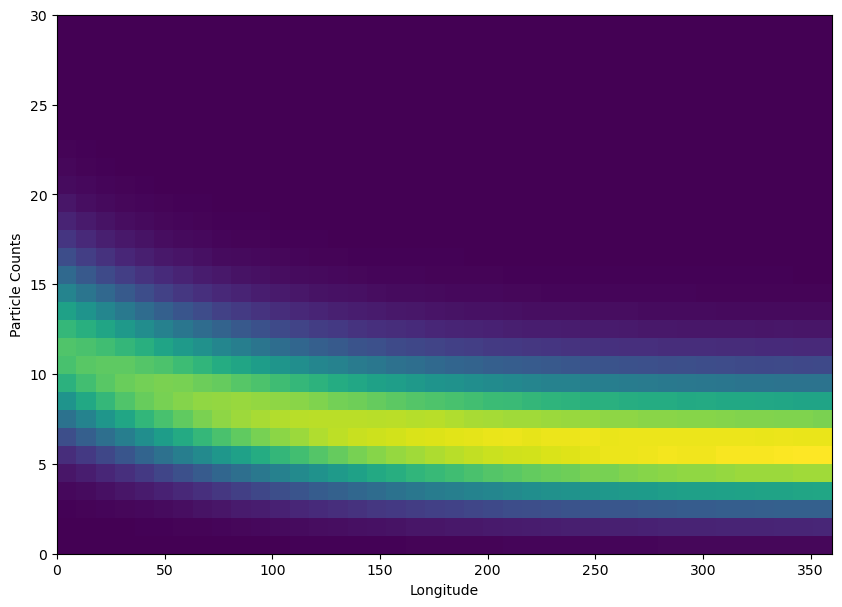

In [17]:
plt.hist2d(longitude,df['Particle Counts'],bins=(40,30));
plt.colorbar()

plt.xlabel('Longitude')
plt.ylabel('Particle Counts');

## 2) Find and describe as accurately as you can how the background changes.

This plot shows how the background changes with longitude, and as I showed earlier, this is directly related to 90 minute orbital periods of the satellite. One thing to note here: The x-axis is wrong, as it actually starts at longitude of 315. With time, the background distribution of particle counts is at its max at longitude of 315 and falls off with what appears to be exponential decay; flattening out around 6 particle counts from 200 to 360 relative degrees.  

## 3) Create a model for the background that includes time dependence, and explicitly compare your model to the data. How good is your model of the background?

Since the data is poisson, the time dependance of the data can be approximated by the average. So here I calculate and plot the average of the particle counts by longitude -- shifted by 45 degrees still.

In [18]:
df2 = df.sort_values(by = 'Longitude', ignore_index = True)
df2 

,Time,Solar Phase,Longitude,Particle Counts
0,941008741.0,294.846962,0.000000,4.0
1,941186941.0,8.932378,0.000000,6.0
2,942061741.0,307.169878,0.000000,18.0
3,941165341.0,272.679601,0.000000,7.0
4,942720541.0,2.879601,0.000000,6.0
...,...,...,...,...
25919996,942396540.9,359.080822,359.993333,8.0
25919997,943211940.9,32.623183,359.993333,10.0
25919998,942391140.9,335.017627,359.993333,9.0
25919999,941186940.9,8.925266,359.993333,7.0


In [19]:
#there's gotta be a better way to calculate average, this takes forever

x = np.linspace(0.5,360,720)
avg = []
idx = 0
length = len(df2['Particle Counts'])
for a in x:
    tot = 0
    val = 0
    amt = 0
    while val < a and idx < length:
        val = df2['Longitude'][idx]
        tot += df2['Particle Counts'][idx]
        idx+= 1
        amt += 1
    avg.append(tot/amt)

In [20]:
#some code I wrote a while back to make a running average to smooth plots
def boxcar_avg(data, width=1):

    if width < 1:
        width = 1

    car_width = 1 + 2*width

    running_avg = []
    for i in range(len(data)):

        avg = data[i]
        for a in range(1, width+1, 1):
            if (-1 + width) < i < (len(data) - width):
                avg += data[i+a] + data[i-a]
            else:
                score = i - a
                score2 = i + a

                if score >= 0 and score2 <= (len(data) - 1):
                    avg += data[i+a] + data[i-a]
                elif score >= 0:
                    avg += data[i-a]
                elif score2 <= (len(data)-1):
                    avg += data[i+a]
        running_avg.append(avg)
    running_avg2 = []
    for a in running_avg:
        running_avg2.append(a/car_width)
    return running_avg2

In [21]:
idx_jump = np.argwhere(np.where(x>314,x,np.inf)<315)[0][0]
new_avg = avg[idx_jump:] + avg[:idx_jump]

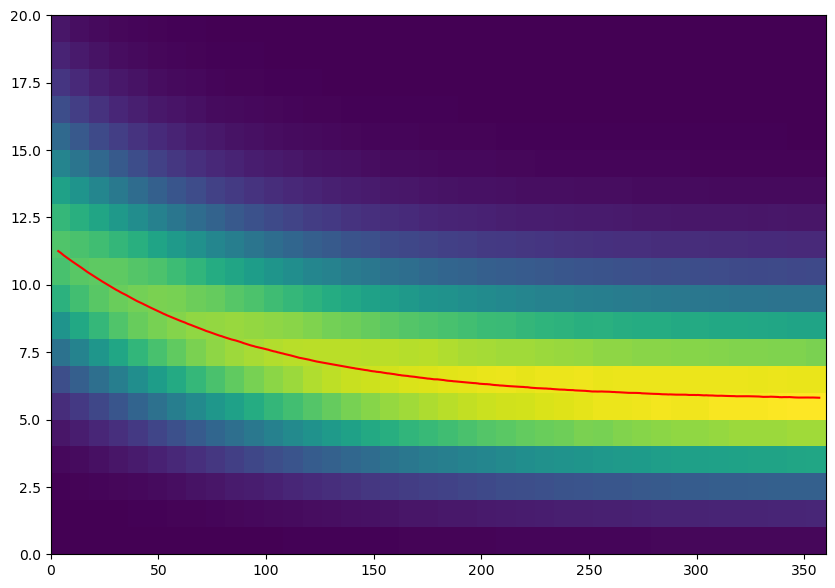

In [22]:
longitude = (df2['Longitude'] + 45) % 360
plt.plot(x[6:-6],boxcar_avg(new_avg,4)[6:-6],color='r')
plt.hist2d(longitude,df2['Particle Counts'],bins=(40,30))
plt.ylim(0,20);

Here, I tried to fit an expontial with the average. Because we haven't learned how to do this, I had to guess and check all the parameters by hand:

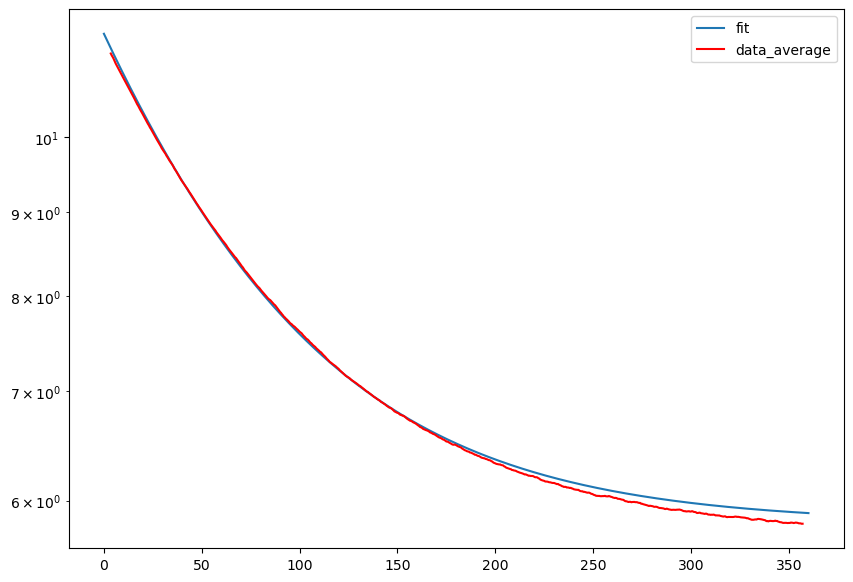

In [23]:
t = np.linspace(0,360,3600)
exp = new_avg[2]*(1/(1.98*np.exp(t/84.8))) + new_avg[-5]

plt.plot(t,exp, label = 'fit')

plt.plot(x[6:-6],boxcar_avg(new_avg,4)[6:-6],color='r', label = 'data_average')

plt.yscale('log')
plt.legend();

This model seems to be a decent fit to my data, only varying noticably from 200 to 360 degrees longitude. I'm sure a better fit is possible, but I did my best with the tools I know.

## 4) Because the background varies, your discovery sensitivity threshold (how many particles you would need to see) also varies. What is the '5-sigma' threshold for a 100 millisecond GRB at different times?

In [24]:
def calc_five_sigma(avg):
    return stats.poisson.ppf(stats.norm.cdf(5),mu=avg)
    

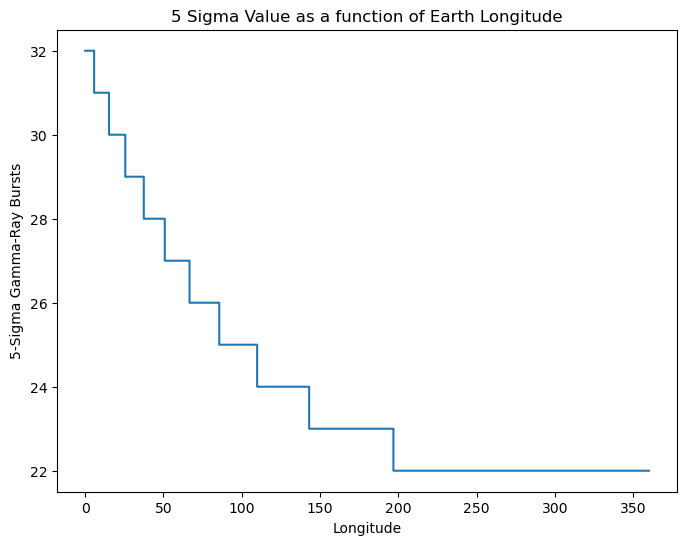

In [369]:
plt.step(t,calc_five_sigma(exp))
plt.xlabel('Longitude')
plt.ylabel('5-Sigma Gamma-Ray Bursts')
plt.title('5 Sigma Value as a function of Earth Longitude');

# Problem 2

## 1) Dowload the data from images.h5. This is a stack of 10 square images, each 200 pixels on a side.

In [26]:
hf = h5py.File('images_lab4.h5', 'r')

In [27]:
hf.keys()

<KeysViewHDF5 ['image1', 'imagestack']>

In [28]:
hf

<HDF5 file "images_lab4.h5" (mode r)>

In [87]:
image1 = np.array(hf.get('image1'))

In [76]:
imgstack = np.transpose(np.array(hf.get('imagestack')))

In [77]:
imgstack.shape

(10, 200, 200)

In [79]:
imgstack[0].shape

(200, 200)

# 2) Explore the data. Is there signal contamination? Is the background time dependent? Is it consistent spatially? Develop a plan to calculate your background pdf().

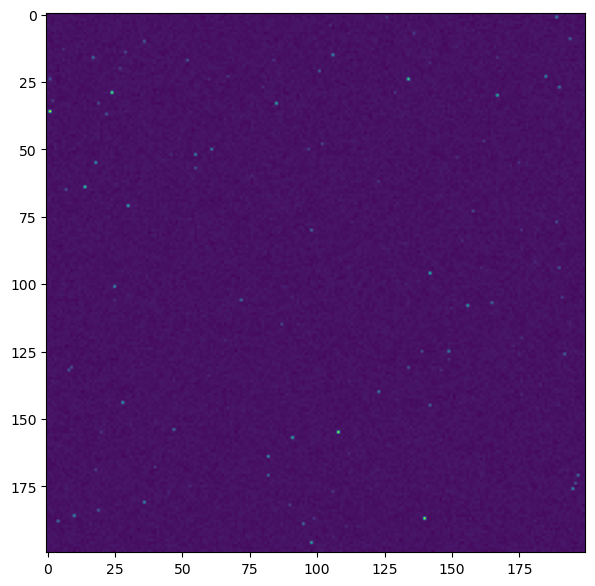

In [88]:
plt.imshow(image1)

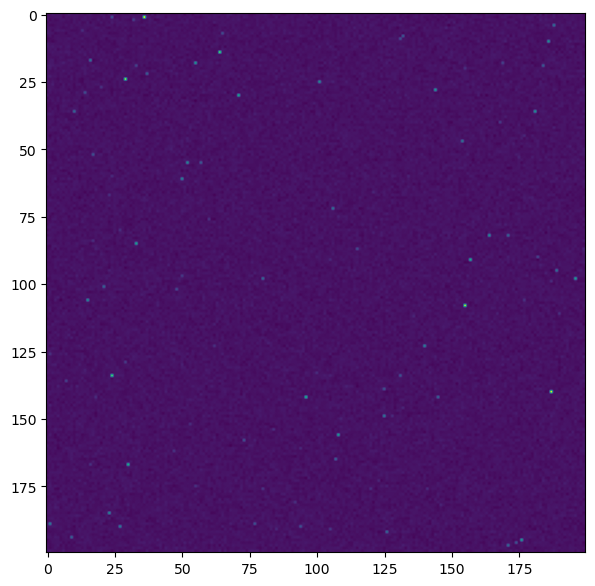

In [80]:
plt.imshow(imgstack[0])

In [92]:
def get_counts(image):
    pixel_vals = []
    for i in range(len(image[0])):
        for a in range(len(image[1])):
            pixel_vals.append(image[i][a])
    return pixel_vals

In [102]:
a = imgstack[0].flatten()

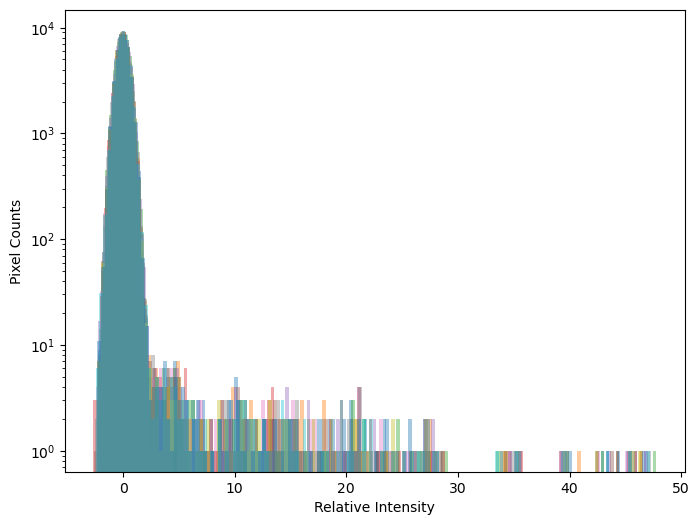

In [372]:
for image in imgstack:
    a = image.flatten()
    plt.hist(a,bins=150,alpha=0.4)
plt.hist(image1.flatten(),bins=150,alpha=0.4)
plt.yscale('log')
plt.title('')
plt.ylabel('Pixel Counts')
plt.xlabel('Relative Intensity');

As we can see from this, the gaussian centered at 0 is the background and the skew to the right is data. We knew the skew isn't part of the background because it is not symmetic (i.e. we do not have negative intensity stars). Next I isolate the peak by finding the most negative value and using it as a cutoff for the background distribution.

In [155]:
minimum = 0
idx_min = 0

for idx,image in enumerate(imgstack):
    if min(image.flatten()) < minimum:
        minimum = min(image.flatten())
        idx_min = idx
print(minimum,idx_min)

-2.709336827866645 3


In [220]:
dist = imgstack[3].flatten()
gaussian = []
for a in dist:
    if minimum <= a <= -minimum:
        gaussian.append(a)

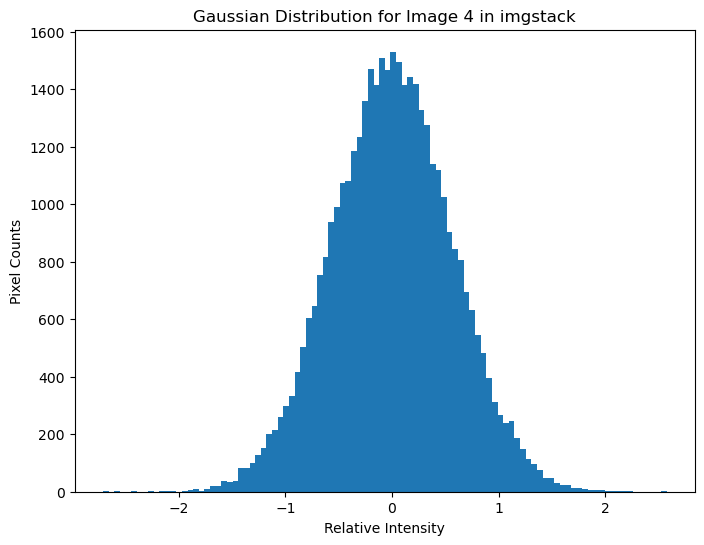

In [371]:
plt.hist(gaussian,bins=100)
plt.title('Gaussian Distribution for Image 4 in imgstack')
plt.ylabel('Pixel Counts')
plt.xlabel('Relative Intensity');

Now I fit a gaussian curve to this with a standard deviation of 0.55:

In [291]:
std = 0.55
width = 3.8
x = np.linspace(-width,width,40000)
dist = stats.norm.pdf(x=x,loc=0,scale=std)

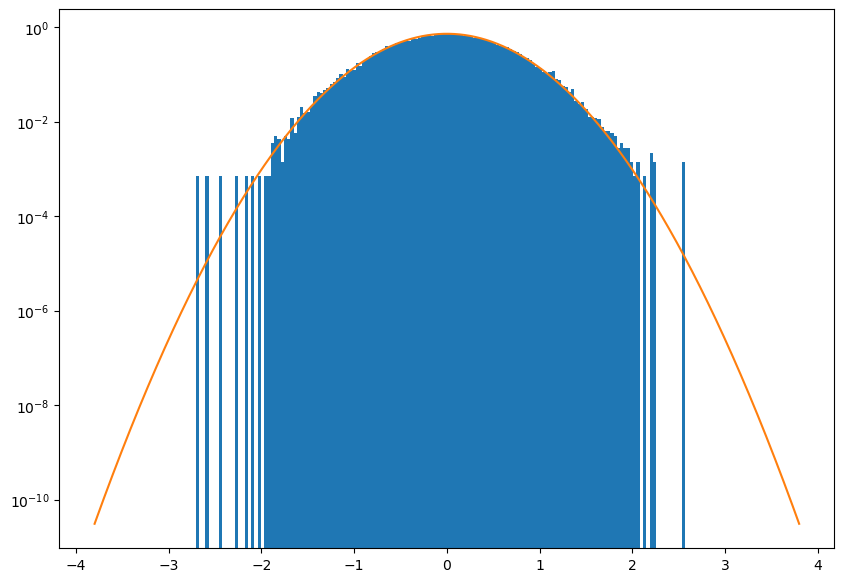

In [292]:
plt.hist(gaussian,bins=150,density = True)
plt.plot(x,dist);
plt.yscale('log')
plt.ylabel('Probabilty')
plt.xlabel('Relative Intensity');



now plotting this onto the full distribution:

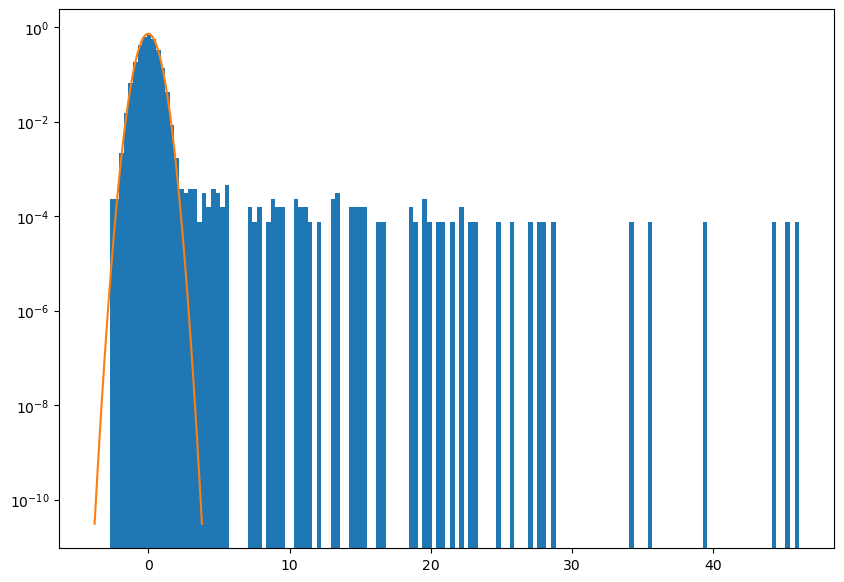

In [297]:
plt.hist(imgstack[3].flatten(),bins=150, density = True)
plt.plot(x,dist)
plt.yscale('log')
plt.ylabel('Probabilty')
plt.xlabel('Relative Intensity');

we want to know if the background is time dependent so I will repeat this plot for each image:

In [307]:
def do_thing(image,std=0.55):
    dist = image.flatten()
    minimum = -min(dist)
    gaussian = []
    for a in dist:
        if -minimum <= a <= minimum:
            gaussian.append(a)
    
    std = 0.55
    width = minimum
    x = np.linspace(-width,width,40000)
    dist = stats.norm.pdf(x=x,loc=0,scale=std)
    
    plt.rcParams["figure.figsize"] = (8,6)
    plt.hist(gaussian,bins=150,density = True)
    plt.plot(x,dist);
    plt.yscale('log')
    plt.ylabel('Probabilty')
    plt.xlabel('Relative Intensity')
    plt.show()

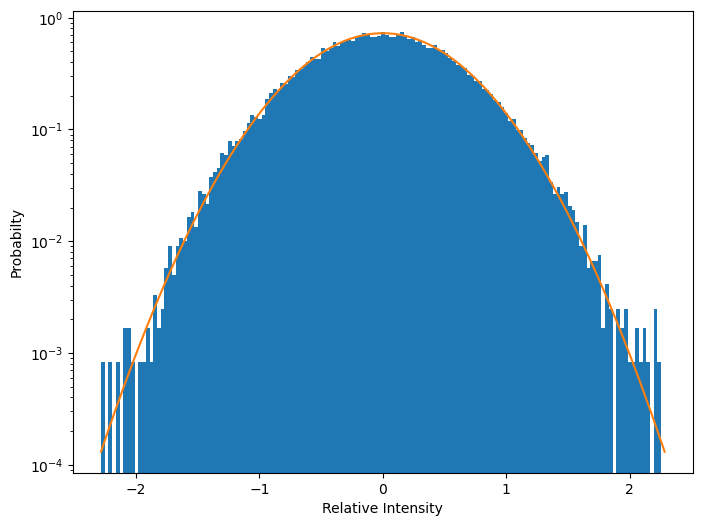

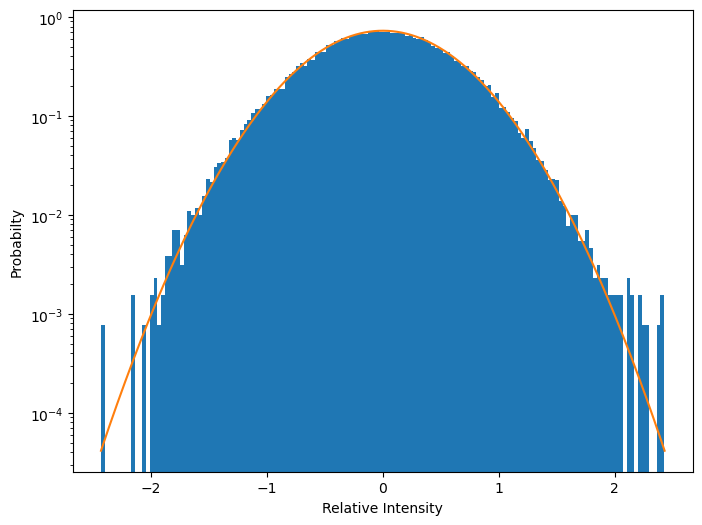

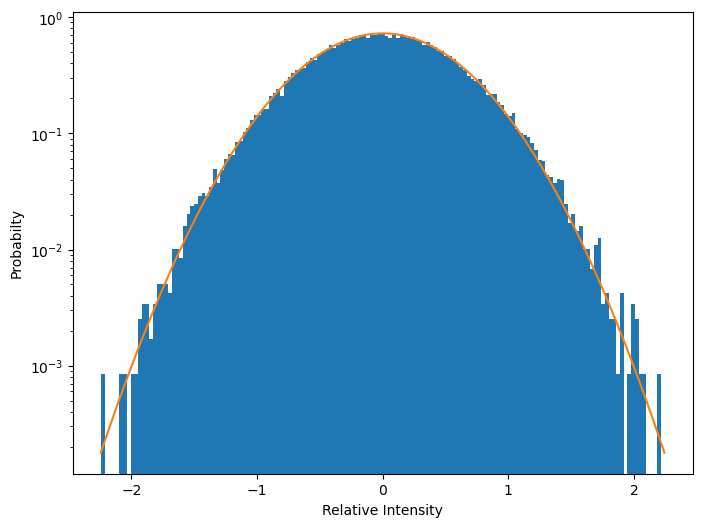

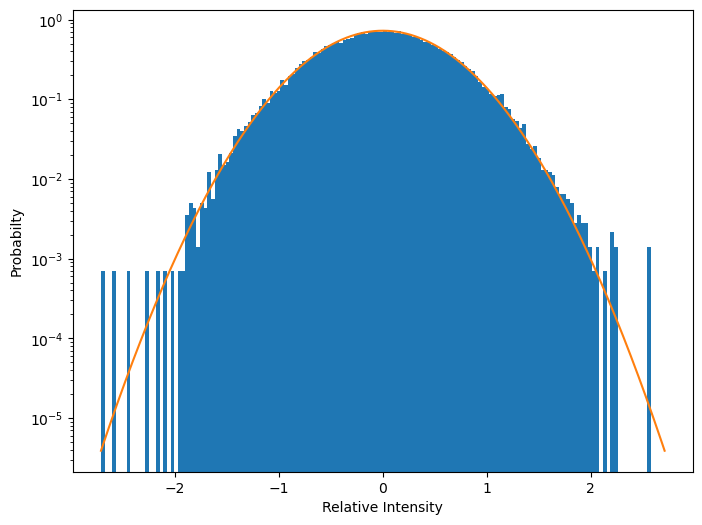

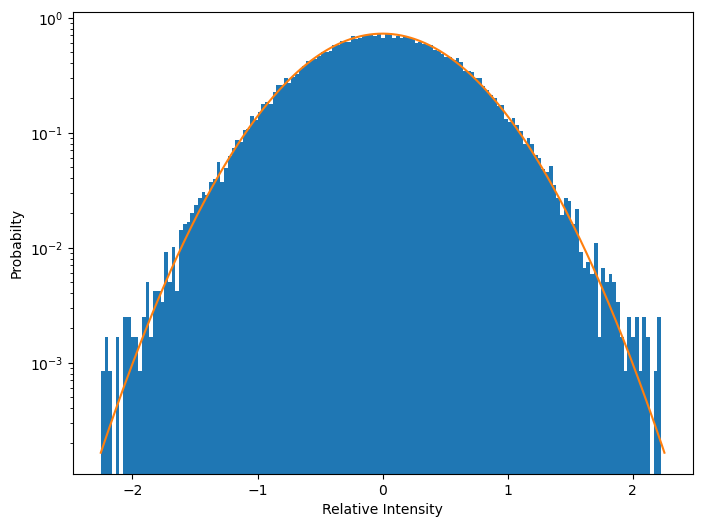

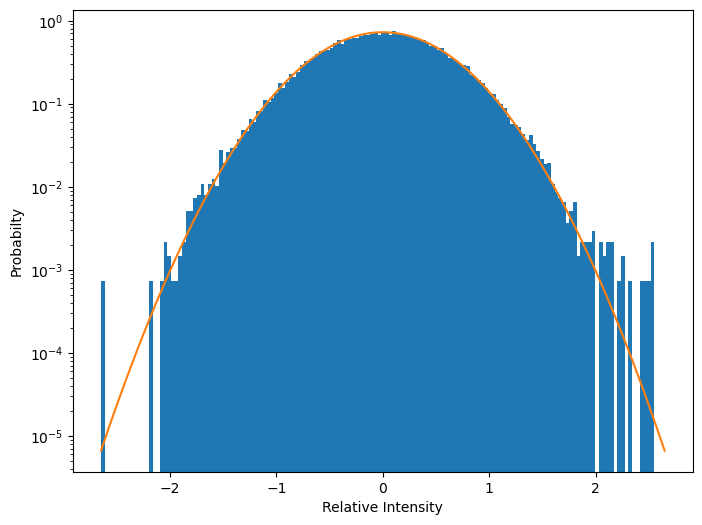

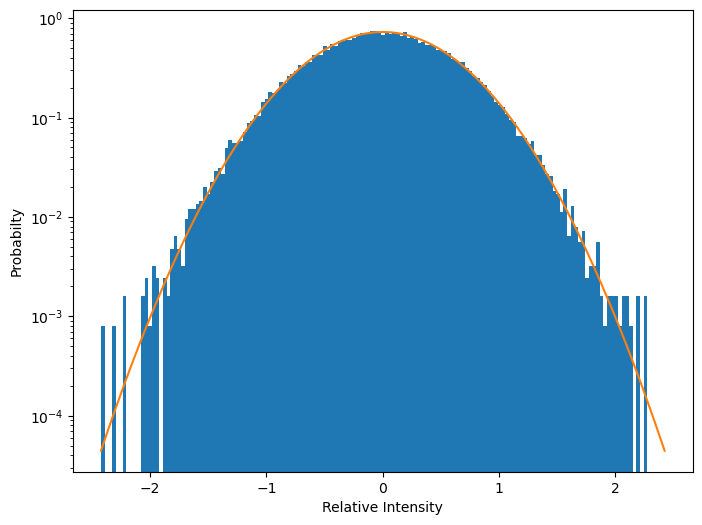

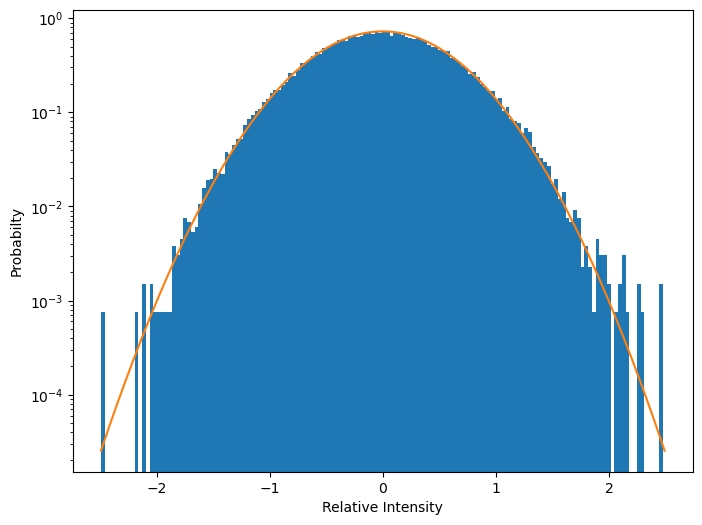

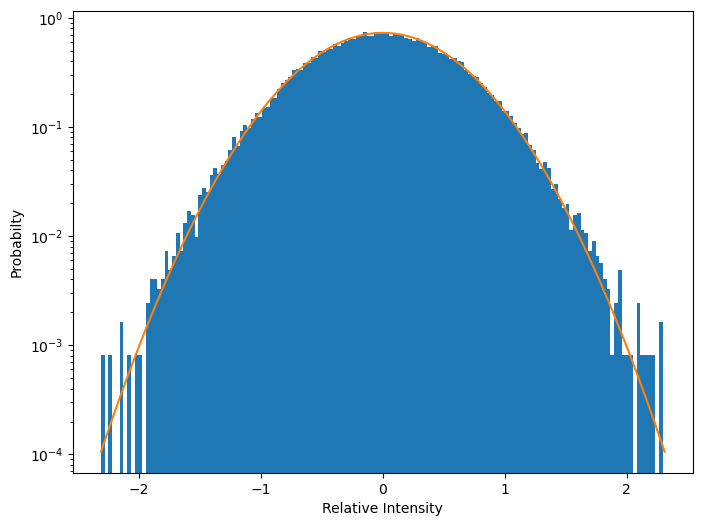

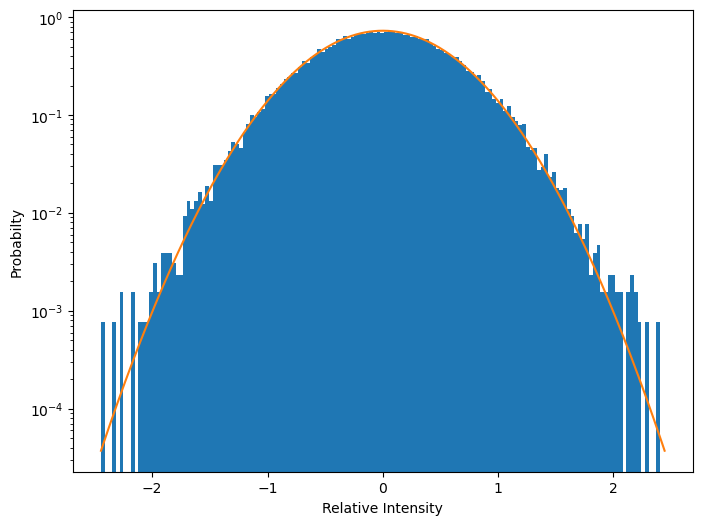

In [308]:
for i in imgstack:
    do_thing(i)

We can see that the Gaussian background distribution is not time dependent, so fluctuations in the intensity values are due to stars or transients. 

# 3) Using your background distribution, hunt for your signal (either faint stars, or a transient). Describe what you find.
Since we have 40,000 pixels in each image, to expect to see a pixel at an intensity would be 40,000 * probability = 1.

In [311]:
prob = 1/40000

intensity = stats.norm.ppf(1-prob,scale = 0.55)

In [312]:
intensity

2.230594839617049

I will also state that "obvious" stars are stars above 5-sigma, which is:

In [324]:
prob = stats.norm.sf(5)
five_sigma = stats.norm.ppf(1 - prob/40000,scale=0.55)

In [325]:
five_sigma

3.714976845374295

So now I will look for stars between 2.23 and 3.7 intensity, which may be good candidates for faint stars.

In [359]:
def find_faint(img):
    faint_stars = np.where(img>2.23,img,100)
    faint_stars = np.where(faint_stars<3.7,a,0)
    return faint_stars

In [365]:
def plot_faint_stars(image):
    fig, ax = plt.subplots(1, 2)

    faint_stars = find_faint(image)
    ax[0].imshow(image)
    ax[1].imshow(faint_stars)

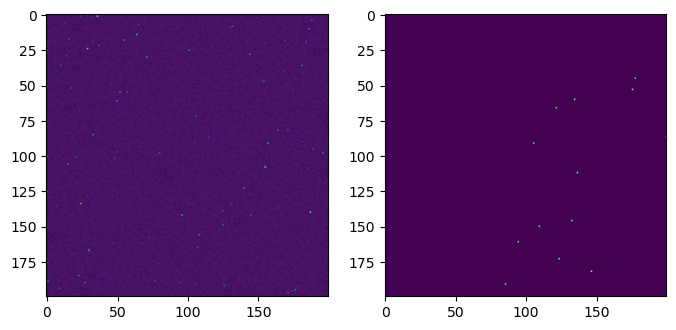

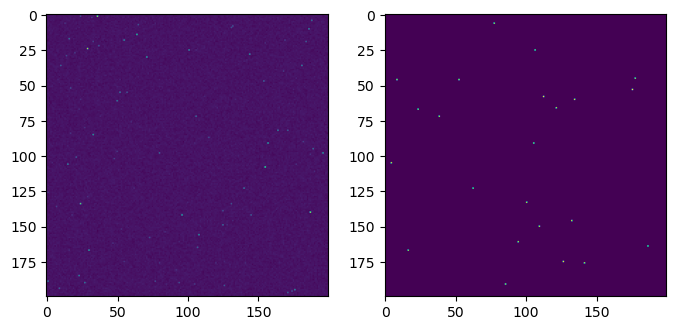

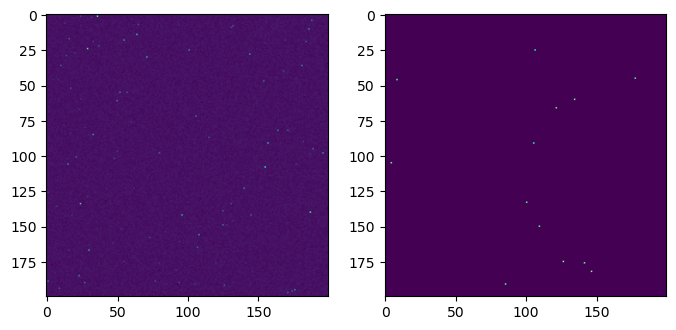

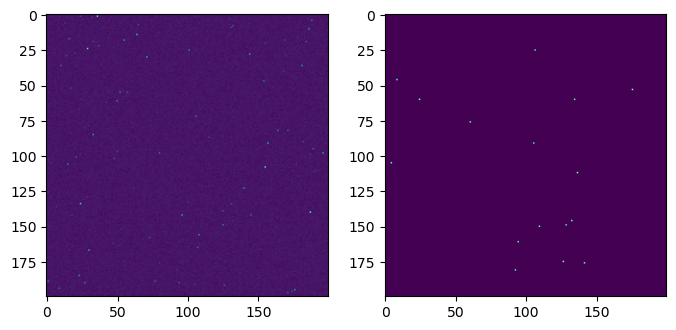

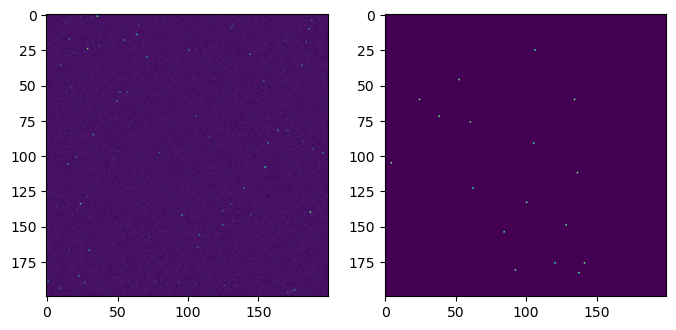

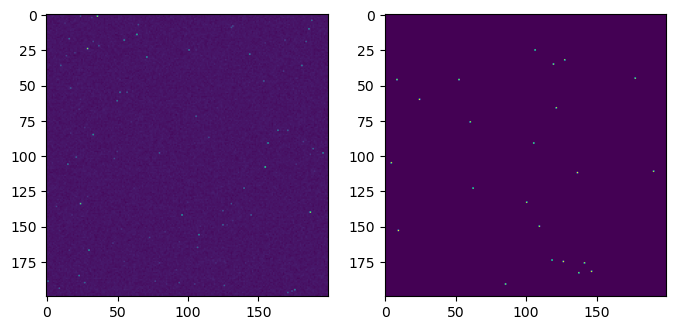

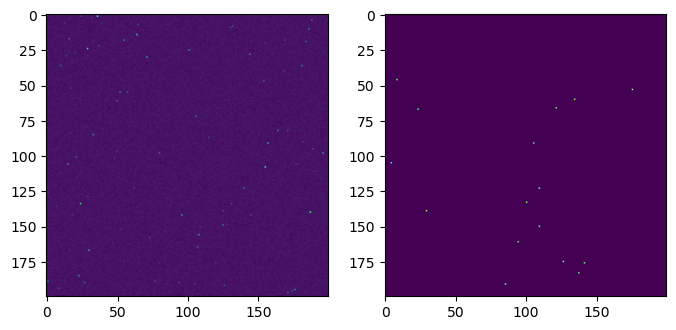

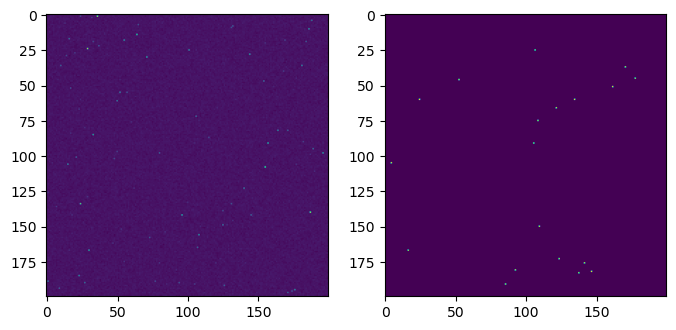

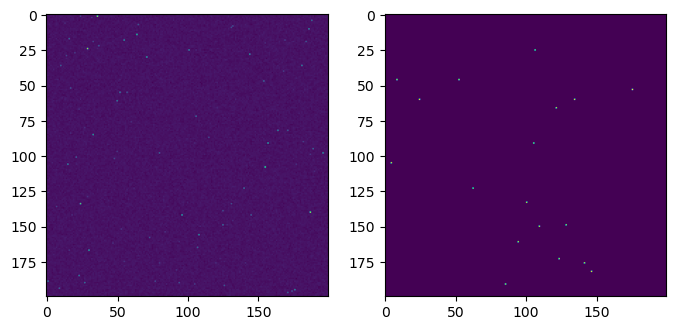

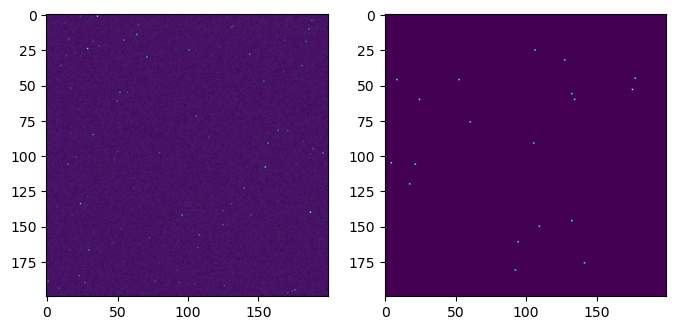

In [366]:
for i in imgstack:
    plot_faint_stars(i)

Apologies, I have run out of time to analize these plots properly. Here I have plotted the original images on the left with the stars between 2.3 and 3.7 intensity on the right. There is clearly some overlap and I believe the next step in this research would be to look for faint stars that show up in the same location on multiple images -- these could be confirmed as true faint stars. 

# 4) You and your lab partner had different pdf(), but were using the same data. Explore why this is.
Because I have to consider not only the distribution of background but also the distribution of stars, while my partner need only consider the distribution of background and search for outlier values within the stars.